# Amazon

## Parsing

In [1]:
import pandas as pd
import os
from transcript_functions import *
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline  

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\spong\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
files = consolidate_files_others('Target')

In [3]:
%%time
# parse into paragraphs
df = filenames_to_para(files)

Wall time: 24.3 s


## Preprocessing

In [4]:
%%time
df["tokens"] = df["paragraph"].map(nltk.word_tokenize)

# tag Part of Speech
df["tokens_pos"] = df["tokens"].map(nltk.pos_tag)

## to check distribution of POS tags
# df_all_tokens = get_all_wordsPos(df["tokens_pos"])

# filter words with pos not in pos_remaining
pos_remaining = ["NN", "NNS", 
                 "VB", "VBD", "VBN", "VBP", "VBZ"
                ] # take out "JJ", "JJR", "JJS"
df["tokens_pos"] = df["tokens_pos"].map(lambda x: [tup for tup in x if tup[1] in pos_remaining])

# lemmatize with POS
lemmatizer = WordNetLemmatizer()
df["tokens_clean"] = df["tokens_pos"].map(lambda x: [lemmatizer.lemmatize(tup[0], get_wordnet_pos(tup[1])) for tup in x ])

# remove rows that have no content after lemmatization
df = df[df["tokens_clean"].map(lambda x: len(x)>=1)]

# remove punctuation
punctuation = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~..."
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if word.lower() not in punctuation])

# remove stop words
stop_words = set(stopwords.words('english'))
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if word.lower() not in stop_words])

# remove some specific cases
others = ["'s", "'re", "'ve", "n't", "'ll", "–", "'m"]
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if word.lower() not in others])

# lower case
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word.lower() for word in x])

df = df[df["tokens_clean"].map(lambda x: len(x)>=1)]

# # remove short words
# df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if len(word)>3])

# # remove long words
# df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if len(word)<16])

Wall time: 24.9 s


In [19]:
# removing some words
removing_words = [
    "get", "think", "thing", "know", "kind", "way", "look", "year",
     "question", "guy", "thank", "quarter", "lot", "want", "herein",
    "talk", "guess", "see", "say", "make", "go", "store", "customer",
    "business", "time", "ph", "take", "bit", "work", "morning", 
    "company", "mean", "wraptext", "”", '’',
    "guest"
]
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if word.lower() not in removing_words])

## filter out rows containing too few words/tokens
df["len_clean"] = df["tokens_clean"].map(len)
df = df[df["len_clean"]>10]

# removing disclaimer
df = df[df["paragraph"].map(lambda x: "The information in the transcripts" not in x)]
df = df[df["paragraph"].map(lambda x: "disclaimer" not in x.lower())]

In [6]:
# removing some paragraphs
removing_words = ["www.streetevents.com"]

mask = df["tokens_clean"].map(lambda x: removing_words[0] not in x)
df = df[mask]

# removing short paragraphs
df = df[df.len_clean > 22]

## Check omni's tag

In [84]:
# df["tokens_pos"] = df["tokens"].map(nltk.pos_tag)
# tokens_pos = df["tokens_pos"]
# key_word = "omni"
# check = get_unique_words(tokens_pos)
# check = pd.DataFrame(check)
# check["pos"] = check.index
# check[check["pos"].map(lambda x: key_word in x[0])]

,0,pos
"(omni-channel, JJ)",10,"(omni-channel, JJ)"
"(omnichannel, NN)",10,"(omnichannel, NN)"
"(omnichannel, JJ)",4,"(omnichannel, JJ)"
"(omni-channel, NN)",3,"(omni-channel, NN)"
"(omni, JJ)",2,"(omni, JJ)"
"(omni-offering, NN)",1,"(omni-offering, NN)"
"(omni, RP)",1,"(omni, RP)"
"(omni-retail, NN)",1,"(omni-retail, NN)"
"(omni, NNS)",1,"(omni, NNS)"
"(omni-retail, JJ)",1,"(omni-retail, JJ)"


In [12]:
# # look at unique words to get a sense what needs to be delete
# unique_words = get_unique_words(df["tokens_clean"])

## LDA

In [7]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [21]:
# prepare count vector as the input of LDA model
df["corpus"] = df["tokens_clean"].map(lambda x: ', '.join(x))
count_vectorizer = CountVectorizer()
count_data = count_vectorizer.fit_transform(df["corpus"])

number_topics = 10

# fix random_state at 33
lda = LDA(n_components=number_topics, n_jobs=-1, random_state =0)
lda.fit(count_data)
       
number_words = 12
# print_topics(lda, count_vectorizer, number_words)

words = count_vectorizer.get_feature_names()

# print topics and key words
for topic in range(0,number_topics):
    topic_vec = lda.components_[topic]
    topic_idx = topic_vec.argsort()[:-10 - 1:-1]
    print("topic:", topic + 1, " ====================")
    for i in topic_idx:
        print('{:<10} {:>10.2%}'.format(words[i], topic_vec[i]/topic_vec.sum()))

topic: 1  ====================
sale            3.08%
growth          2.75%
continue        1.97%
performance      1.55%
team            1.53%
category        1.40%
share           1.36%
traffic         1.35%
result          1.34%
plan            1.22%
topic: 2  ====================
team            2.33%
continue        1.60%
investment      1.44%
service         1.23%
chain           1.22%
supply          1.13%
fulfillment      1.13%
order           1.10%
day             0.97%
need            0.92%
topic: 3  ====================
order           2.15%
inventory       1.65%
team            1.61%
experience      1.36%
pickup          1.24%
item            1.20%
capability      1.07%
stock           0.98%
effort          0.86%
process         0.84%
topic: 4  ====================
brand           2.91%
category        2.51%
item            1.94%
product         1.93%
assortment      1.60%
apparel         1.37%
price           1.34%
home            1.33%
holiday         1.21%
season          

## Visualize topic distribution

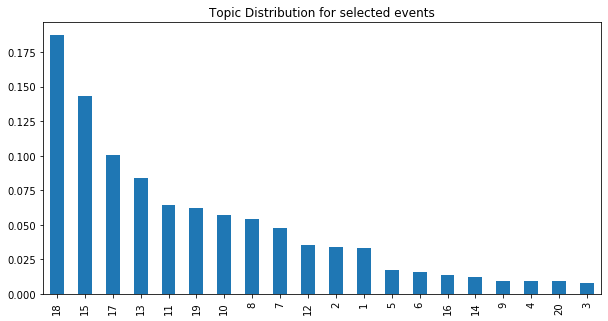

In [9]:
# assign topic to paragraphs
topic_match = lda.transform(count_data)
df["topic"] = [ x.argsort()[-1] + 1 for x in topic_match]

# # chech how many topics in each paragraphs
# df["number of topics"] = [sum(x>x.mean()) for x in topic_match]

topic_counts = df["topic"].value_counts()
(topic_counts/topic_counts.sum()).plot(x="Topics", y="percentage",
                                       title="Topic Distribution for selected events",
                                       kind="bar", figsize=(10,5))

## Visualize paragraph counts for each year

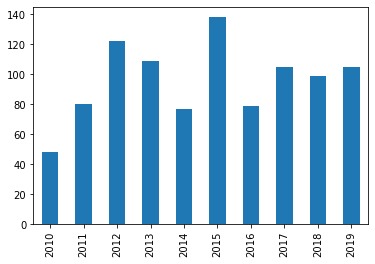

In [10]:
# df['quarter'] = pd.PeriodIndex(df.date, freq='Q')
df['year'] = pd.PeriodIndex(df.date, freq='Y')
df["year"].value_counts().sort_index().plot(kind='bar')

## Topic trends

In [11]:
tmp = pd.crosstab(df["year"], df["topic"], normalize="index")
years = [ str(x) for x in tmp.index]

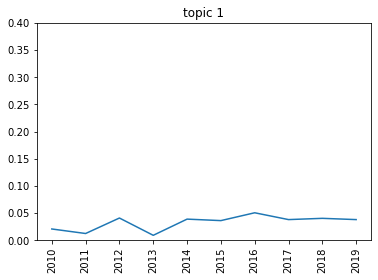

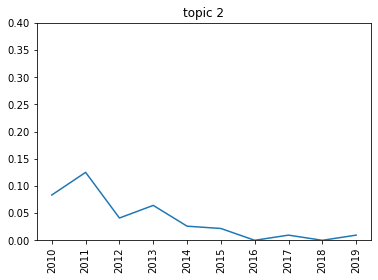

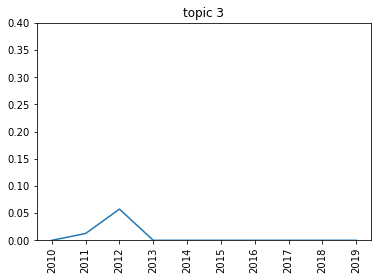

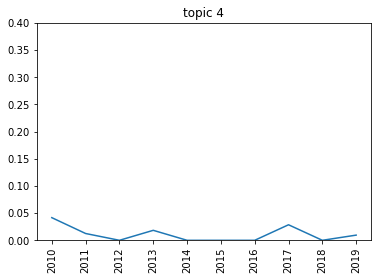

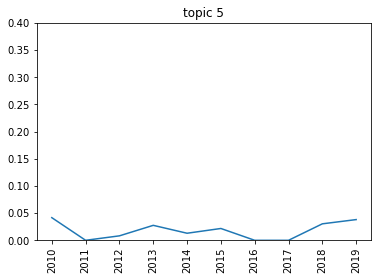

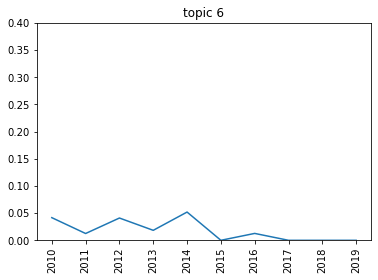

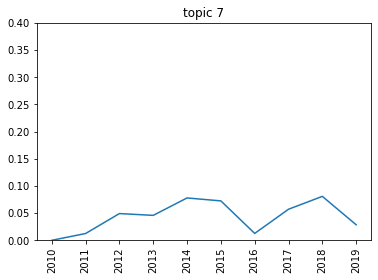

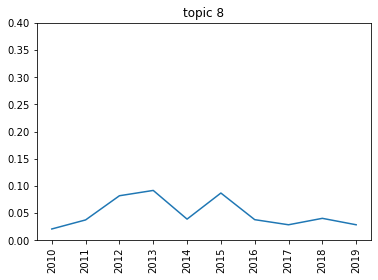

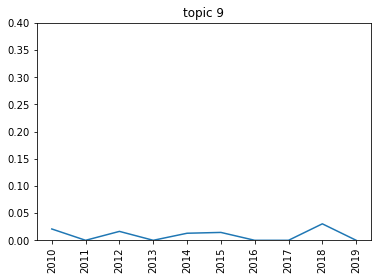

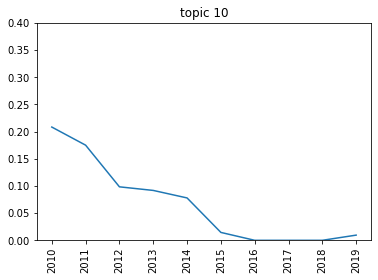

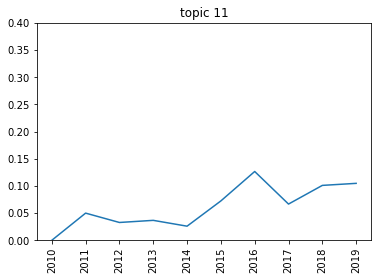

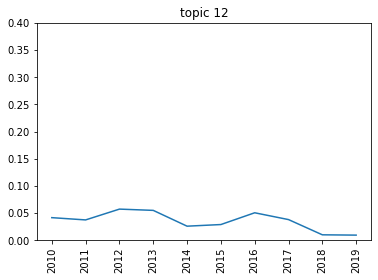

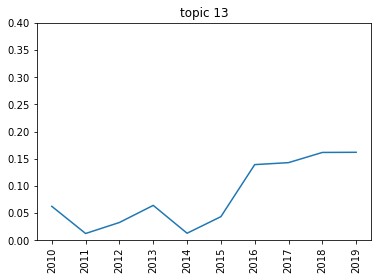

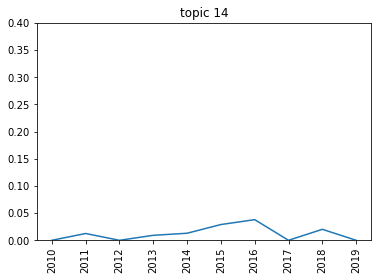

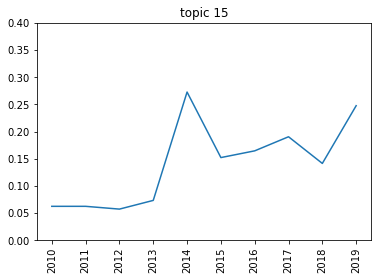

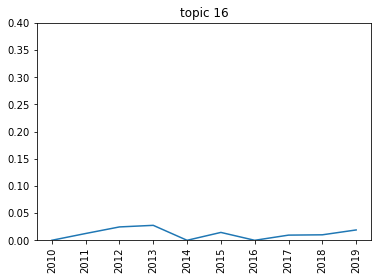

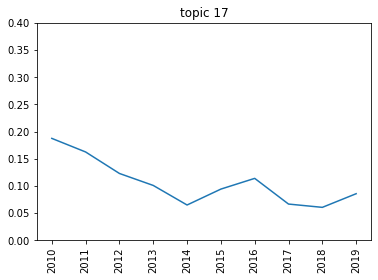

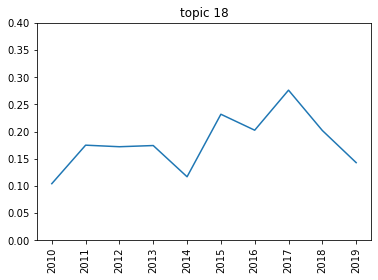

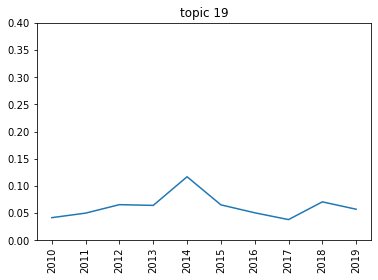

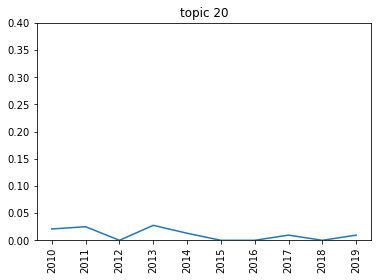

In [12]:
for topic in tmp:
    fig, ax = plt.subplots()
    plt.plot(years, tmp[topic].values)
    plt.ylim(0, 0.4)
    plt.xticks(years, years, rotation='vertical')
    plt.title("topic "+ str(topic))

In [14]:
check = df[df["topic"]==11]
check[check["year"] == 2017]["paragraph"].iloc[0].replace("WRAPTEXT", "")

' Los Angeles , as we ’ ve remodeled stores in Texas that as we bring in new  experience that drives traffic to our stores .  As Mark and his team continue to roll out these new proprietary brands that  are unique to Target , that drives traffic to both our stores and our site . And  we ’ ve seen that with Cat & Jack , a billion-dollar brand in year one on its way  to being the number one kids brand in America . So as we continue to  elevate brands , those drive traffic to both our stores and our site . As we  move into our new urban neighborhoods , it ’ s striving for traffic every single  day .  So and as we think about how this smart network comes together , brands  play an important role that in-store experience is critically important being in  the right neighborhoods , but then we also know from a digital standpoint  more and more of our guests are ordering online and conveniently coming to  our stores to pick up that order . That allows us to really make sure that once  they ’ r

In [27]:
## search for certain key word
keyword = "guest"
a = check[check["paragraph"].map(lambda x: keyword in x)]

In [29]:
a["paragraph"].iloc[10].replace("WRAPTEXT", "")

' Brian Cornell  Let me talk about the owned brand investments we ’ re making and then let  Cathy talk through the RX implications . But , as we have consistently talked  about throughout the last year and year and a half now , we think one of the  things that differentiates Target is the value ; the quality of the innovation  we bring to our own brands . So , we ’ re clearly looking to make sure we bring  more value to our owned brands . I talked about the number of handcrafted  items we are going to have for the fourth quarter . And we ’ re being very  surgical with those investments . But we ’ re seeing a great reaction from the  guest as we elevate the value we offer in our owned brands . So , we ’ ll be  very surgical , very selective but we ’ re certainly seeing a great return  through the investments we ’ re making .'

## Interactive visualization

In [16]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

Wall time: 43.4 s


C:\Users\spong\Anaconda3\envs\test\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [17]:
pyLDAvis.enable_notebook()
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.026300  0.101826       1        1  17.813166
17     0.009495  0.090563       2        1  17.526859
12     0.187639  0.035516       3        1  11.443478
16    -0.022089  0.178016       4        1   9.798540
18     0.216247 -0.010351       5        1   8.464224
9      0.248234 -0.032384       6        1   8.222381
1      0.187397 -0.023155       7        1   4.108575
7     -0.117890  0.111331       8        1   3.990944
10     0.029470  0.106009       9        1   2.940591
6     -0.082069  0.021730      10        1   2.842280
0      0.090587 -0.209195      11        1   2.632200
11     0.080403 -0.004143      12        1   1.896194
13    -0.078501  0.101506      13        1   1.765659
19    -0.090699  0.070514      14        1   1.645432
5     -0.088006  0.001590      15        1   1.283093
8     -0.116864 -0.050367      16        1   1.188055
4     -0.064777 -0.059257      17        1   0.717135
15    -0.117294 -0.107621      18        1   0.638293
2     -0.104990 -0.233405      19        1   0.571693
3     -0.139993 -0.088724      20        1   0.511207, topic_info=     Category         Freq          Term        Total  loglift  logprob
1743  Default  1962.000000         guest  1962.000000  30.0000  30.0000
3342  Default  1693.000000          sale  1693.000000  29.0000  29.0000
437   Default   808.000000         brand   808.000000  28.0000  28.0000
3404  Default   408.000000       segment   408.000000  27.0000  27.0000
840   Default  1415.000000      continue  1415.000000  26.0000  26.0000
3851  Default  1207.000000          team  1207.000000  25.0000  25.0000
1580  Default   291.000000          food   291.000000  24.0000  24.0000
562   Default   932.000000      category   932.000000  23.0000  23.0000
1431  Default  1013.000000        expect  1013.000000  22.0000  22.0000
2892  Default   519.000000       product   519.000000  21.0000  21.0000
245   Default   459.000000    assortment   459.000000  20.0000  20.0000
2285  Default   591.000000        margin   591.000000  19.0000  19.0000
2861  Default   377.000000         price   377.000000  18.0000  18.0000
2994  Default   659.000000          rate   659.000000  17.0000  17.0000
2564  Default   281.000000         order   281.000000  16.0000  16.0000
2707  Default   794.000000   performance   794.000000  15.0000  15.0000
886   Default   285.000000          cost   285.000000  14.0000  14.0000
1836  Default   298.000000          home   298.000000  13.0000  13.0000
2053  Default   477.000000          item   477.000000  12.0000  12.0000
1636  Default   253.000000   fulfillment   253.000000  11.0000  11.0000
587   Default   294.000000         chain   294.000000  10.0000  10.0000
3427  Default   332.000000       service   332.000000   9.0000   9.0000
1928  Default   643.000000      increase   643.000000   8.0000   8.0000
1439  Default   417.000000       expense   417.000000   7.0000   7.0000
1440  Default   648.000000    experience   648.000000   6.0000   6.0000
3442  Default   650.000000         share   650.000000   5.0000   5.0000
3781  Default   267.000000        supply   267.000000   4.0000   4.0000
2031  Default   561.000000    investment   561.000000   3.0000   3.0000
4112  Default   359.000000         value   359.000000   2.0000   2.0000
513   Default   268.000000          call   268.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
3921  Topic20     1.505326          time     5.231944   4.0304  -5.8257
140   Topic20     1.470107   alternative     5.179450   4.0168  -5.8494
1769  Topic20     5.595674        happen    59.534343   2.9116  -4.5127
1763  Topic20     1.488593       handful     6.248004   3.8417  -5.8369
2861  Topic20    10.772177         price   377.554018   1.7194  -3.8578
1836  Topic20     8.932202          home   298.144376   1.7682  -4.0451
2698  Topic20     4.936672       

## Visualize components for each year (stop using for now)

IndexError: list index out of range

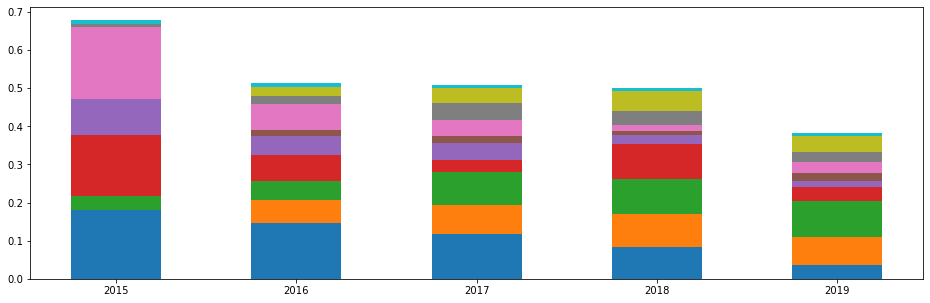

In [144]:
# event_tp = df.groupby(by=["year","topic"])["topic"].count().unstack().fillna(0)
# tmp = event_tp.T.apply(sum)
# event_tp = event_tp.apply(lambda x: x/tmp)
# event_tp.index = [str(x)[:10] for x in event_tp.index]

# fig, ax = plt.subplots(figsize=(16, 5))
# colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 
#           'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# bottom = np.array([0]*event_tp.shape[0])
# x = event_tp.index.values

# for i in event_tp.columns:
# #     print(event_tp[i].values)
#     plt.bar(x, event_tp[i].values, width=0.5, color=colors[int(i-1)], bottom=bottom)
#     bottom = bottom + event_tp[i]

# plt.legend(event_tp.columns)
# plt.title("Topic distribution across events")